In [3]:
"""
Created on Wed Mar 12 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings
import tempfile

import anndata as ad
import matplotlib.pyplot as plt
from matplotlib import rc_context
import numpy as np
import pandas as pd
import scanpy as sc
# import scvi
import seaborn as sns
import torch

In [5]:
seed = 123
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [6]:
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 

In [7]:
os.chdir('/home/wu/datb1/reseq_ppp')

sample_list = os.listdir('second_stage_IL_17_treatment')
sample_list

['PT_PPP_P99_1_10X',
 'PT_PPP_P99_2_10X',
 'PT_PPP_P23_1_10X',
 'PT_PPP_P23_2_10X',
 'PT_PPPC_P99C_10X',
 'PT_PPP_P23_3_10X']

In [8]:
adata_inte = sc.read_h5ad('scanvi_integrated/standard_pipe_processed.h5ad')
adata_inte.obs['IL17_treatment'] = adata_inte.obs['IL17_treatment'].astype('category')
adata_inte

AnnData object with n_obs × n_vars = 69879 × 3000
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'IL17_treatment', 'leiden', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_mde_scanvi', 'X_scANVI', 'X_scVI', 'X_scVI_mde'
    layers: 'counts'

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


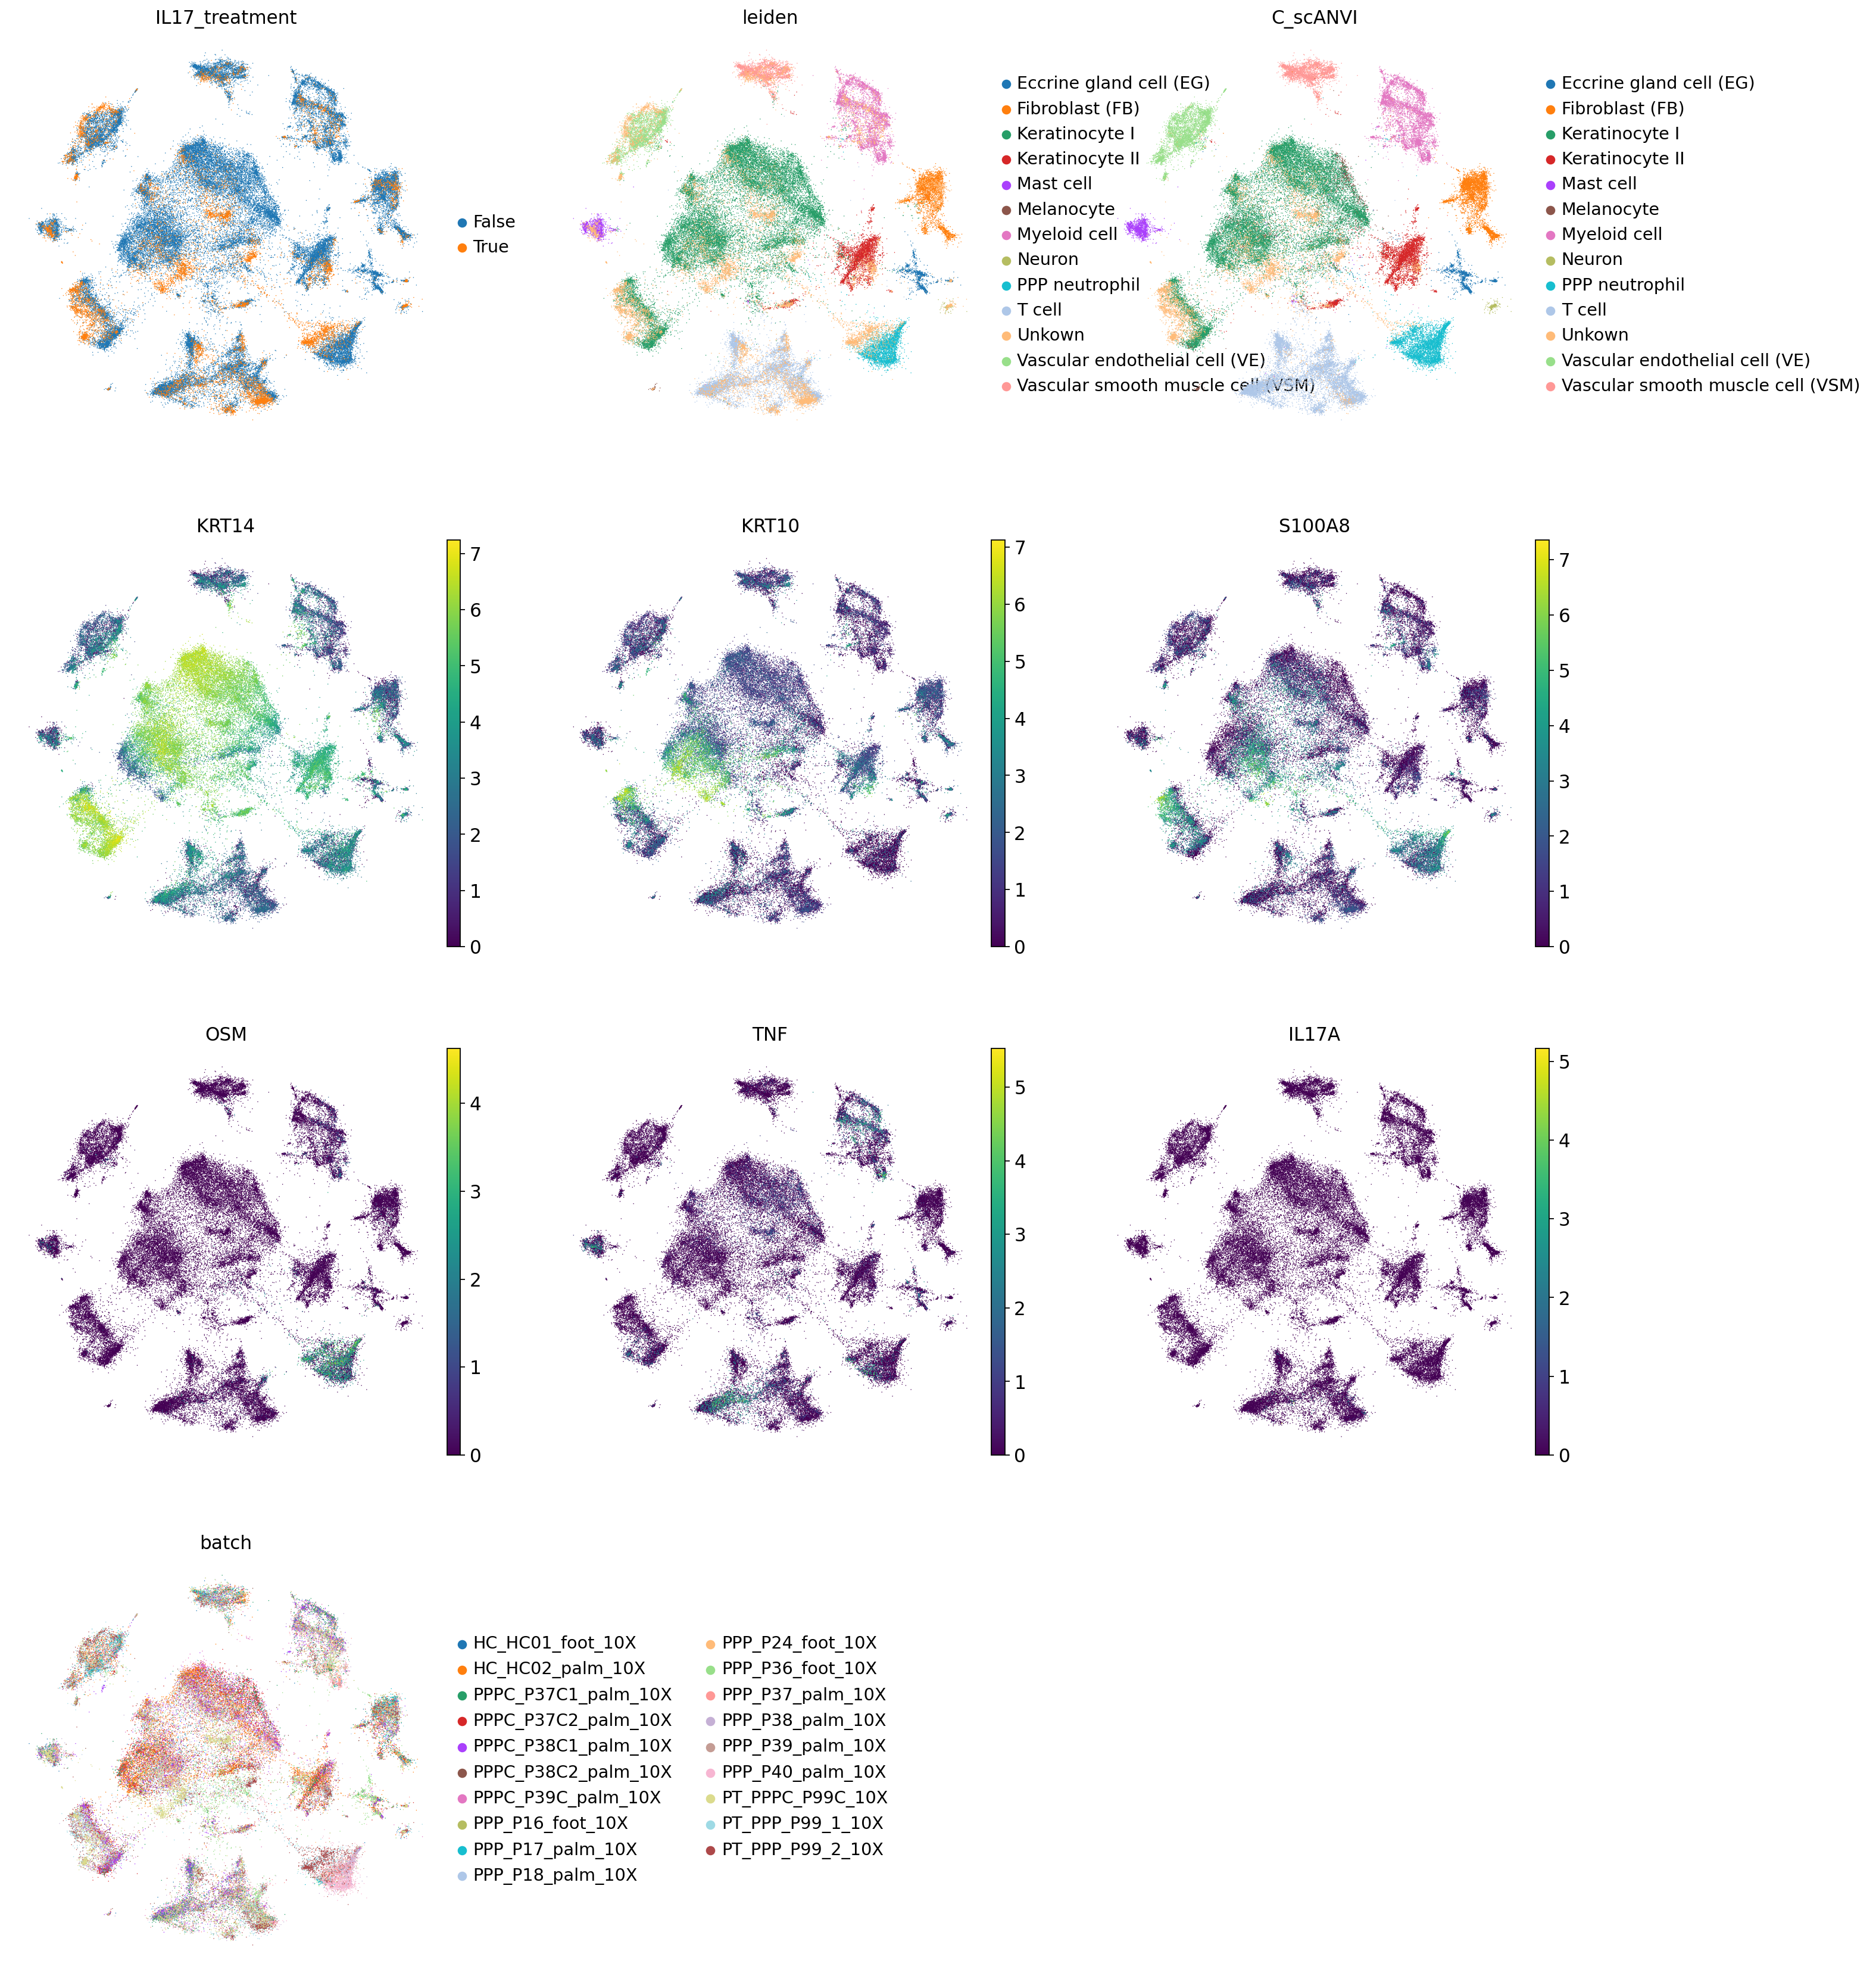

In [9]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.embedding(
        adata_inte,
        basis='X_mde_scanvi',
        color=["IL17_treatment", 'leiden', 'C_scANVI', 'KRT14', 'KRT10', 'S100A8', 'OSM', 'TNF', 'IL17A', 
               'batch'],
        frameon=False,
        ncols=3,   
    )

In [10]:
sc.pp.neighbors(adata_inte, use_rep='X_scANVI', n_neighbors=30)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_scanvi', the cluster labels (adata.obs, categorical) (0:00:09)


/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


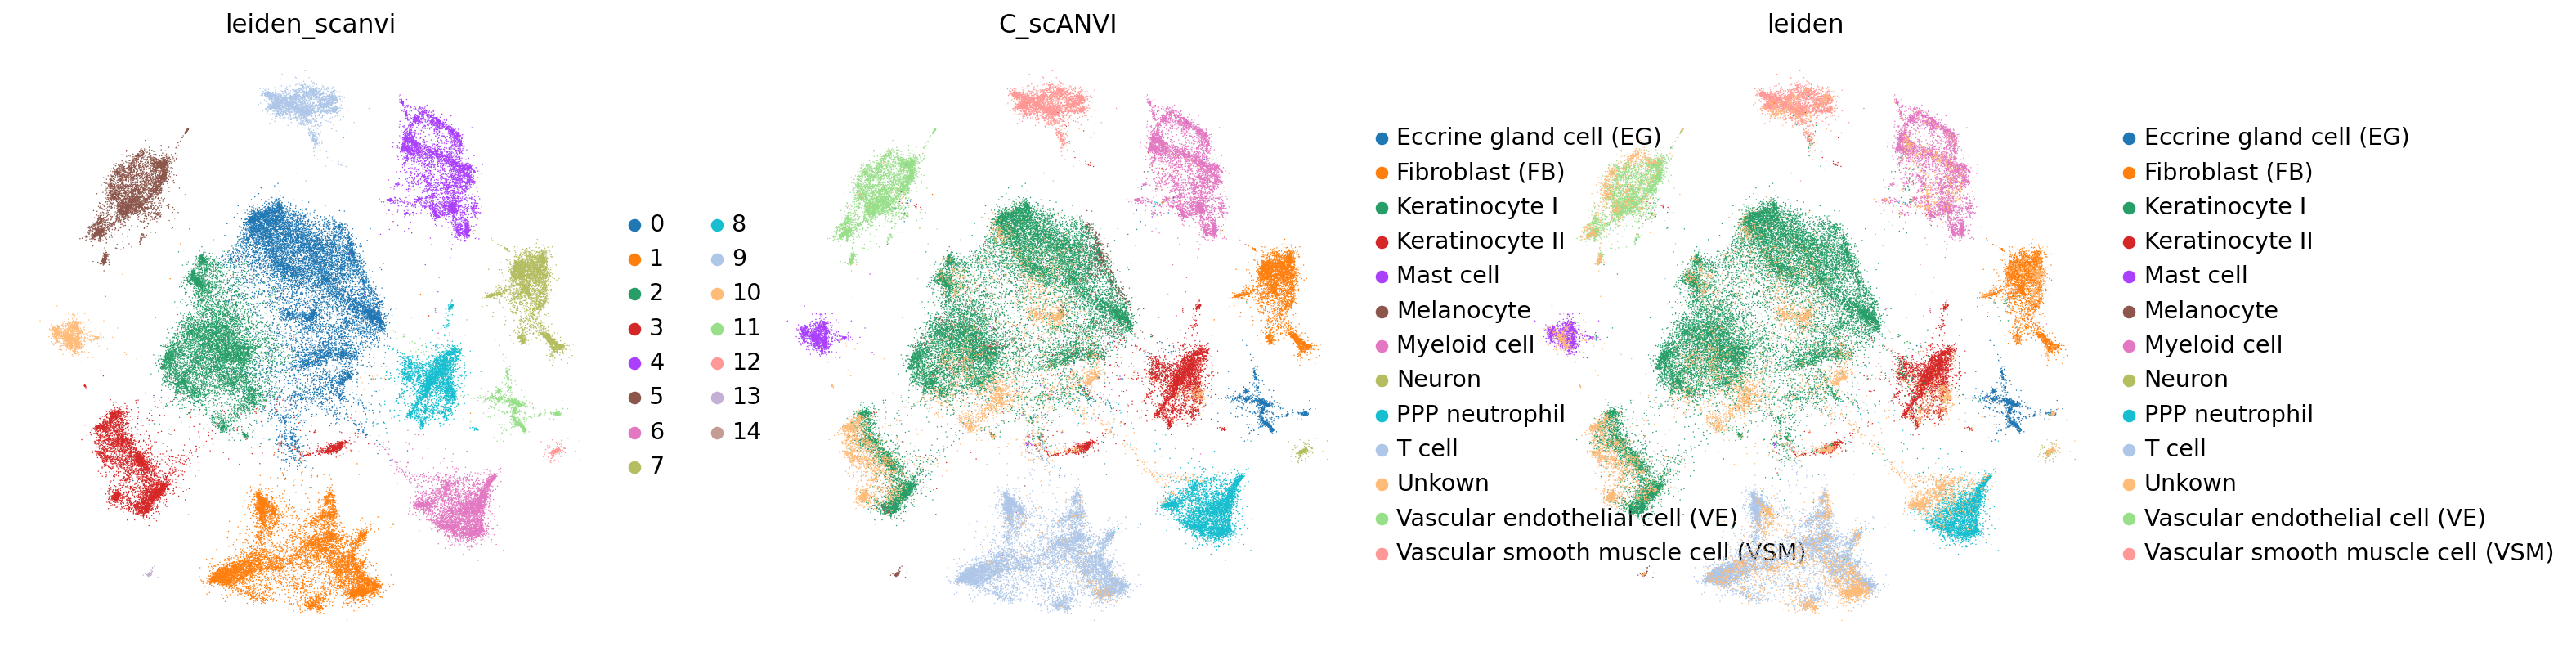

In [11]:
sc.tl.leiden(adata_inte, resolution=0.3, key_added='leiden_scanvi', random_state=seed)
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.embedding(
        adata_inte,
        basis='X_mde_scanvi',
        color=['leiden_scanvi', 'C_scANVI', 'leiden'],
        frameon=False,
        ncols=3,
    )

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


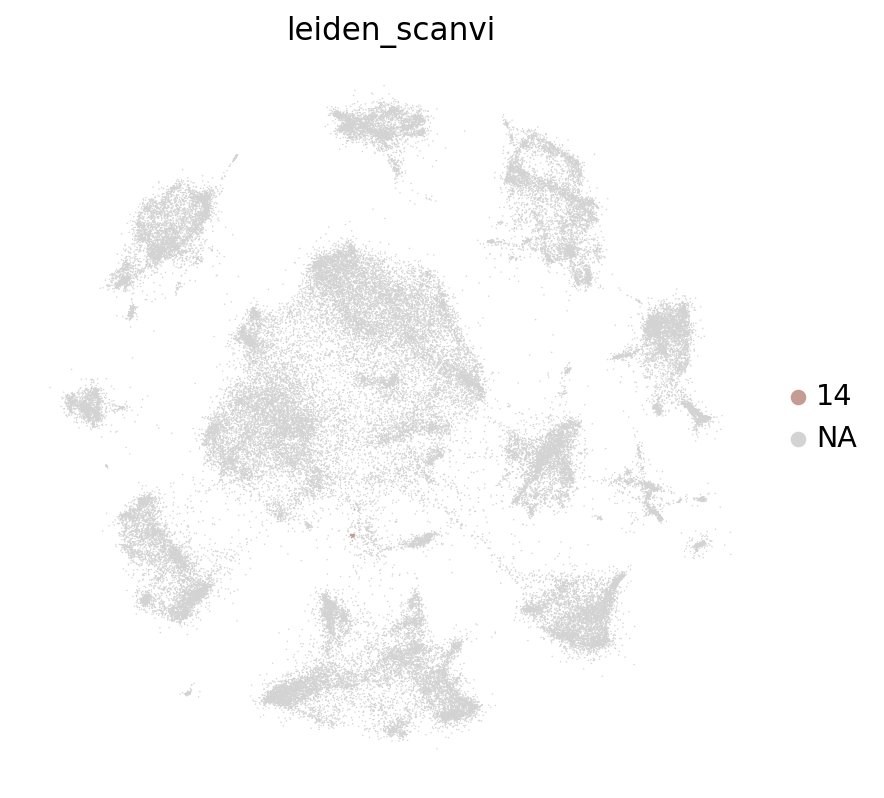

In [14]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.embedding(
        adata_inte,
        basis='X_mde_scanvi',
        color=['leiden_scanvi'],
        groups=['14'],
        frameon=False,
        ncols=3,
    )

In [15]:
marker_genes = ["COL17A1", "KRT5", "KRT14", "KRT1", "KRT10", "KRT6B", "PECAM1","CDH5","VWF","RGS5","TAGLN","ACTA2","DCN","COL1A1","COL6A3",
             "NRXN1","S100B","PLP1","HLA-DRA", "LYZ", "CXCL8", "SOD2", "TNFAIP6", "C15orf48","CCL4L2","ADGRE1",
             "CD3D","CD3E","CD3G","CPA3","TPSAB1","TPSB2","KRT7","KRT19","KRT18","PMEL", "MLANA", "DCT", "DEFB1", "ATP1B1", "MGST1"]

new_cluster_names = {
    '0': 'Keratinocyte',
    '1': 'T cell',
    '2': 'Keratinocyte',
    '3': 'Keratinocyte',
    '4': 'Myeloid cell',
    '5': 'Vascular endothelial cell',
    '6': 'PPP neutrophil',
    '7': 'Fibroblast',
    '8': 'Keratinocyte',
    '9': 'Vascular smooth muscle cell',
    '10': 'Mast cell',
    '11': 'Eccrine gland cell',
    '12': 'Neuron',
    '13': 'Melanocyte',
    '14': 'Keratinocyte',
}

adata_inte.obs['leiden_scanvi'] = adata_inte.obs['leiden_scanvi'].map(new_cluster_names).astype('category')

In [17]:
adata_all = sc.read_h5ad('processed_data/ALL_PPP_10X.h5ad')

In [18]:
adata_all.obs.leiden.cat.categories

Index(['Eccrine gland cell (EG)', 'Fibroblast (FB)', 'Keratinocyte I',
       'Keratinocyte II', 'Mast cell', 'Melanocyte', 'Myeloid cell', 'Neuron',
       'PPP neutrophil', 'T cell', 'Vascular endothelial cell (VE)',
       'Vascular smooth muscle cell (VSM)'],
      dtype='object')

In [19]:
adata_inte.obs.leiden_scanvi = adata_inte.obs.leiden_scanvi.cat.reorder_categories(['Keratinocyte', 'Eccrine gland cell', 'T cell', 'Myeloid cell', 'PPP neutrophil', 
                                                                          'Mast cell', 'Fibroblast', 'Vascular endothelial cell', 'Vascular smooth muscle cell', 'Neuron', 'Melanocyte'])

/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


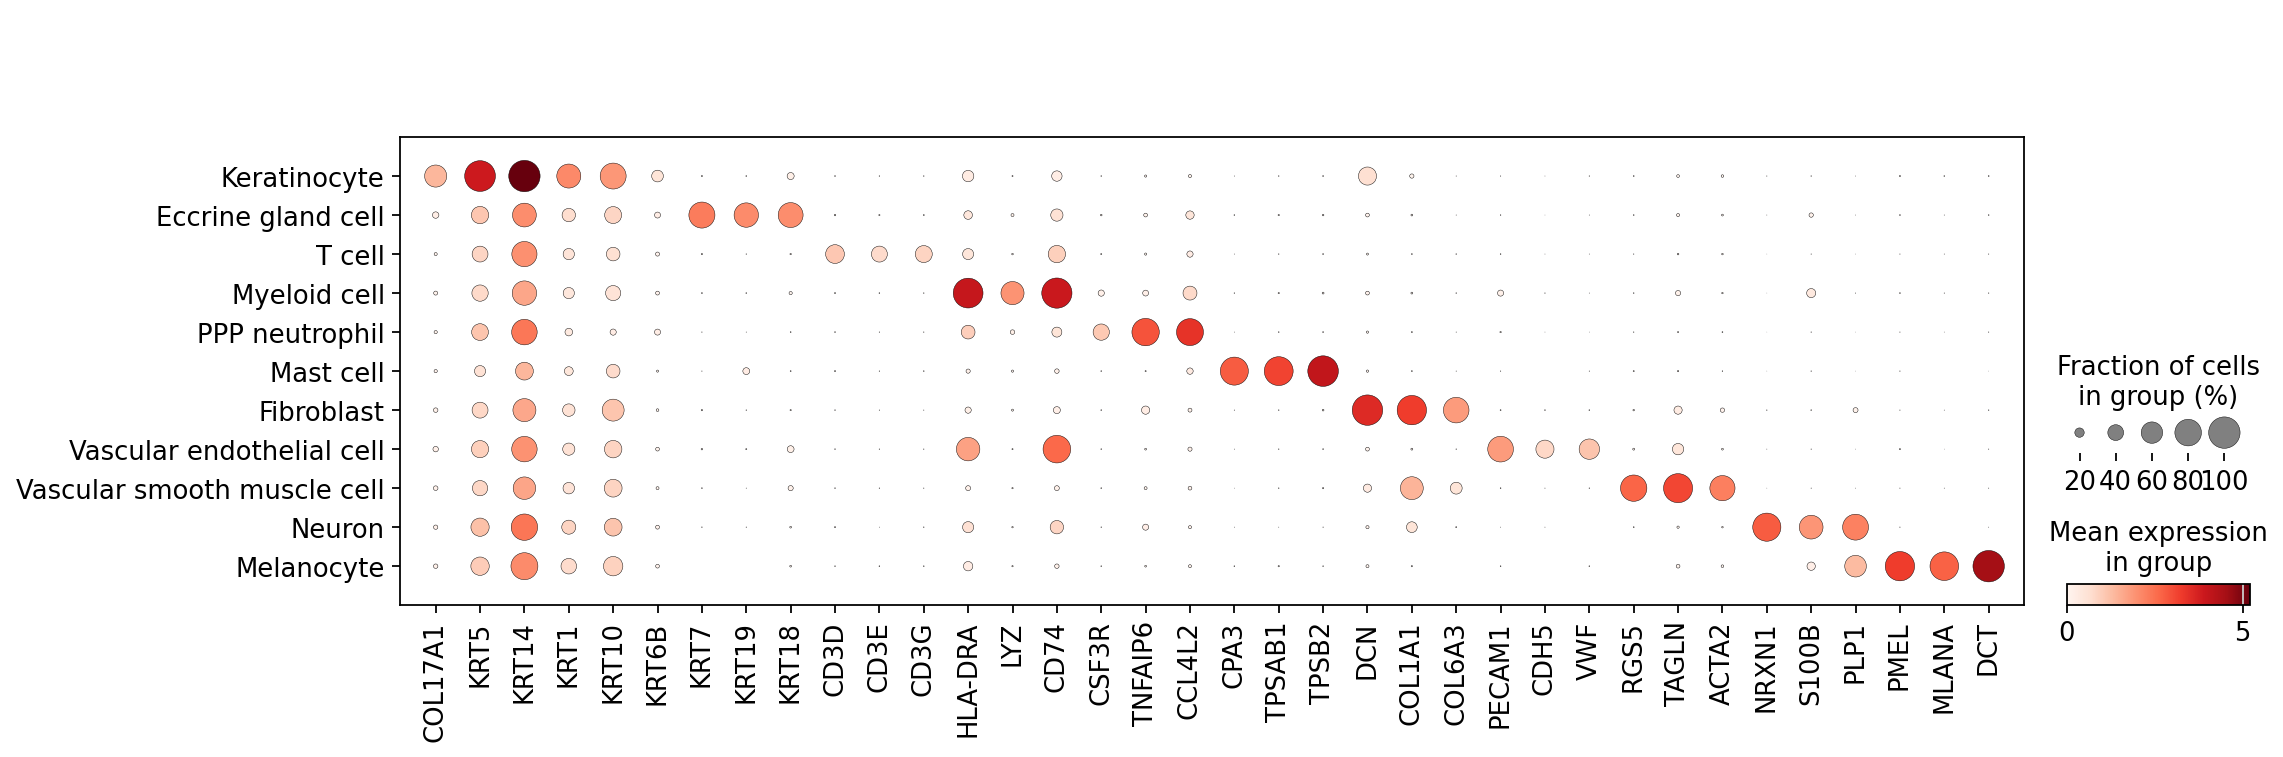

In [20]:
marker_genes = ["COL17A1", "KRT5", "KRT14", "KRT1", "KRT10", "KRT6B", "KRT7","KRT19","KRT18","CD3D","CD3E","CD3G",
                "HLA-DRA", "LYZ", "CD74", "CSF3R", "TNFAIP6","CCL4L2","CPA3","TPSAB1","TPSB2",
                "DCN","COL1A1","COL6A3","PECAM1","CDH5","VWF","RGS5","TAGLN","ACTA2",
                "NRXN1","S100B","PLP1","PMEL", "MLANA", "DCT"]

sc.pl.dotplot(adata_inte, marker_genes, groupby='leiden_scanvi')

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


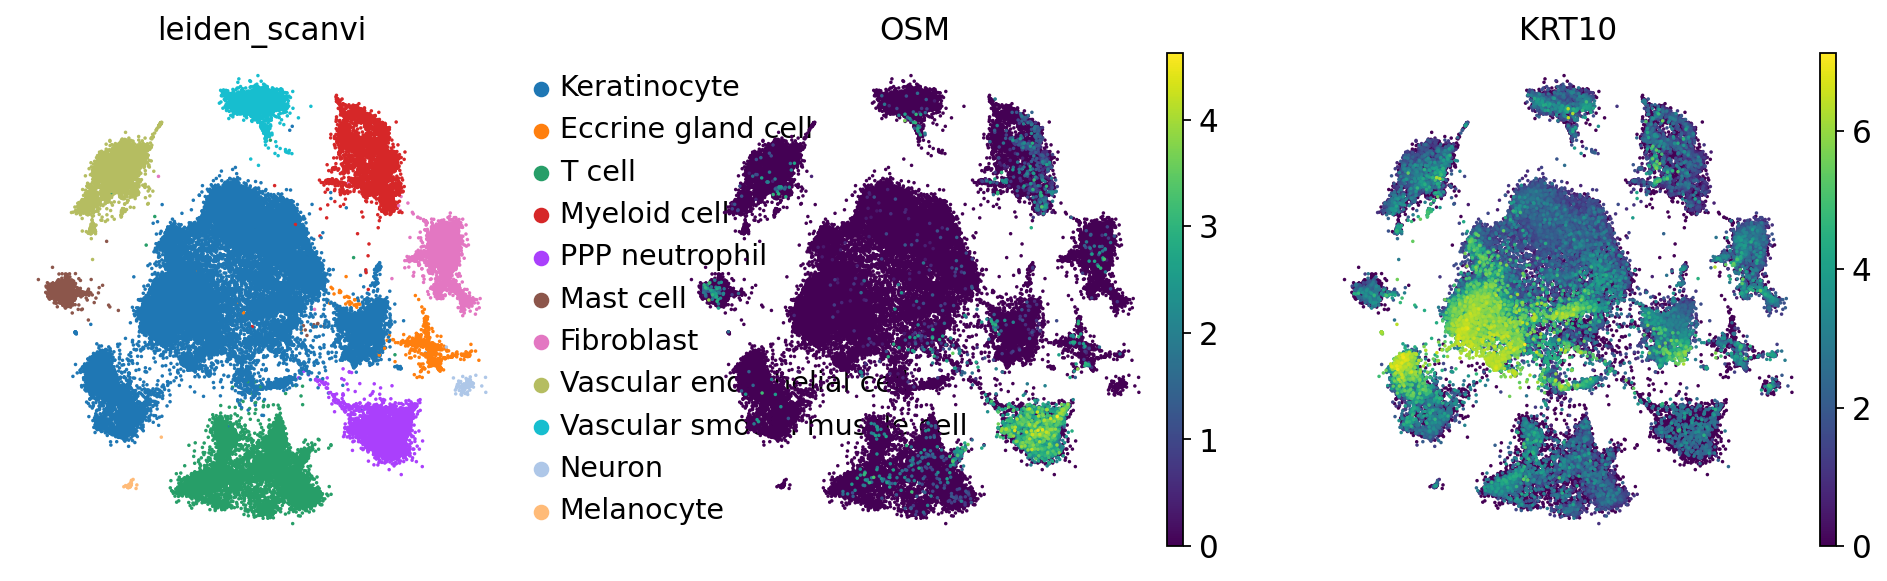

In [21]:
sc.pl.embedding(adata_inte, basis='X_mde_scanvi', color=['leiden_scanvi', 'OSM', 'KRT10'], frameon=False, size=10)

In [22]:
adata_inte.obs['batch_group'] = 'Unknown'
adata_inte.obs.loc[adata_inte.obs.IL17_treatment == False, 'batch_group'] = adata_all.obs['batch_group'].copy().astype(str)
adata_inte.obs.loc[adata_inte.obs.IL17_treatment == True, 'batch_group'] = 'After_IL17_treatment'
adata_inte.obs['batch_group'] = adata_inte.obs['batch_group'].astype('category')

In [23]:
adata_inte.obs.C_scANVI = adata_inte.obs.C_scANVI.cat.rename_categories({'Unkown': 'Unknown'})
adata_inte.obs.leiden = adata_inte.obs.leiden.cat.rename_categories({'Unkown': 'Unknown'})

In [24]:
adata_inte.obs.leiden

PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1    Vascular smooth muscle cell (VSM)
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1                            Mast cell
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1                         Myeloid cell
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1                      Fibroblast (FB)
PPP_P16_foot_10X_AAACCCATCATACGAC-1                      Fibroblast (FB)
                                                     ...                
PT_PPPC_P99C_10X_TTTGTTGAGCGCCGTT-1                              Unknown
PT_PPPC_P99C_10X_TTTGTTGCAGAACTAA-1                              Unknown
PT_PPPC_P99C_10X_TTTGTTGGTGGGATTG-1                              Unknown
PT_PPPC_P99C_10X_TTTGTTGGTTCAATCG-1                              Unknown
PT_PPPC_P99C_10X_TTTGTTGTCGTAATGC-1                              Unknown
Name: leiden, Length: 69879, dtype: category
Categories (13, object): ['Eccrine gland cell (EG)', 'Fibroblast (FB)', 'Keratinocyte I', 'Keratinocyte II', ..., 'T cell', 'Unknown', 'Vascular endothe

In [25]:
# save the integrated data
adata_inte.write('scanvi_integrated/INTEGRATED_ANNO_IL17_treatment.h5ad')